<img src="./notebooks_img/coruai.gif">

## Perceptron multi-capa

En el perceptron simple, somo capaces de diferencias las dos variables de forma independiente. Sin embargo, el hecho de tener la clasificiación basada en una sola capa (entrada y salida) no nos permite hacer una operación como el XOR.

XOR como puerta lógica, devuelve 1 cuando ambos valores son distintos:
    
    x0=0  x0=0  y0=0
    x1=1  x1=0  y1=1
    x2=0  x2=1  y1=1
    x3=1  x3=1  y1=0
    
Esta distribución, una unica capa no nos deja separa los casos. Si los vemos colocados en una gráfica, vemos rápidamente que no es posible con una sola línea. Esa capacidad la conseguimos agregando una primera capa interna.

<img src="https://nasirml.files.wordpress.com/2017/11/xor_11.png" width=240>

Más adelante veremos como definir esta mini red. Como siempre empezaremos por importar las librerías que nos hacen falta.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### Workaround por un bug/conflicto entre la versión de matplot lib y OSX con clang-omp.
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

De la misma forma que hicimos con el perceptron creamos la parametrización e hyper-parametrización de la red.

- num_features: entradas de la red. Configura la capa de entrada.
- num_iter: iteraciónes a realizar por la red
- learning_rate: ratio de aprendizaje para la red, empezamos con el standard 0.01
- num_input: neuronas en al capa de entrada
- num_hidden: neuronas en la capa oculta 1
- num_output: neuronas de salida

<img src="https://nasirml.files.wordpress.com/2017/12/xor_2.png" width=320>

El perceptron simple, usa la capa de entrada y salida en la misma neurona.

In [2]:
num_features = 2
num_iter = 10000
display_step = int(num_iter / 10)
learning_rate = 0.01

num_input = 2          
num_hidden1 = 2        
num_output = 1         

Siguiendo la lógica del ejemplo anterior, pasamos a crear los datos de entrada y la salida esperada. Para TF todo es tratado como tensores (vectores multidimensionales), es por eso que la salida esperada tenemos que redimensionarla a un tensor (4x1).

Ha diferencia del AND del perceptron, la y en este caso es 1 paro los casos lógicos de una XOR.

In [3]:
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], np.float32)  # 4x2
y = np.array([0, 1, 1, 0], np.float32)                      # 4 a pelo esto nos funcionabia
y = np.reshape(y, [4,1])                                    # 4x1 para TF

Una vez más toca usar la API de TF. Recordemos que los placeholders son Variables que no tienen por que ser incializadas en el mismo momento, pero se reserva su espacio; las Variables en si, requiren inicialición en el mismo momento de crearse.

- X: representa los datos de entrada. Lo marcamos como placeholder ya que no se va a incializar hasta que se realice la asignación de variables.
- Y: representa la "etiquetas" 1|0 como salida de la red.
- weights: para los pesos se ha usado la notación implicita que permite TF (útil también para exportar pesos). En este caso, X cubre la entrada y solo necesitamos resevar espacio de Variable para los pesos de la primera capa y para la salida.
- biases: lo mismo que los pesos aplica a los segos, con la diferencia que que la dimensionlidad es 1. Recordemos que los sesgos se aplican como una entrada más a la red en cada capa.


In [4]:
X = tf.placeholder('float', [None, num_input]) 
Y = tf.placeholder('float', [None, num_output])    

# weights and biases
weights = {
    'w_h1' : tf.Variable(tf.random_normal([num_input, num_hidden1])), 
    'w_out': tf.Variable(tf.random_normal([num_hidden1, num_output]))
}

biases = {
    'b_h1' : tf.Variable(tf.zeros([num_hidden1])),
    'b_out': tf.Variable(tf.zeros([num_output]))
}

Ahora si, definimos la funcion 100% con metodos de tensor flow. Como se puede ver es un modelo sencillo. la x de entreda con los pesos y segos se usan para la definición de la primera capa oculta.

En este caso también usaremos un optimizador, gradiente descendente, para localizar el mínimo absoluto o el mínimo local lo más rápido posible.

Con Keras veremos que es más sencillo y claro de modelar. Con TF, al principio cuesta tener en mente como "anidar las capas" cuando vayamos a correr la sesion.

In [5]:
def multi_layer_perceptron_xor(x, weights, biases):

    hidden_layer1 = tf.add(tf.matmul(x, weights['w_h1']), biases['b_h1'])
    hidden_layer1 = tf.nn.sigmoid(hidden_layer1)

    out_layer = tf.add(tf.matmul(hidden_layer1, weights['w_out']), biases['b_out'])

    return out_layer

Lo siguiente es construir el modelo. TensorFlow introduce el concepto de session. tf.Session() guarda el estado de las variables y se encarga de ejecutar las operaciones.

sess.run(opers) lanza las operaciones en la secuencia dada.

- creamos el modelo. entrada -> h1 -> output
- reduce_sum, hace la suma del resultado de aplicar la función de coste
- agregamos el optimizador, en este caso un gradiente descente, al que le pasamos el ratio de aprendizaje
- como "objectivo" del optimizador fijamos que se minimice la función de coste



In [6]:
model = multi_layer_perceptron_xor(X, weights, biases)
loss_func = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=model, labels=Y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss_func)

Para ejecutar el modelo creamos una session en la cual ejecutamos las siguientes acciones:

- sess.run -> Inicializar las variables. `global_variables_initializer` devuelve una operación de TF.

Para cada iteración:
- sess.run -> ejecuta, [función de coste -> función de activación] , y recibe como entrada los valores x e y. A través de la sesión se controla el flujo de operaciones y estado de los tensores.


In [9]:
sess = tf.Session()
init = tf.sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

for k in range(num_iter):
    tmp_cost, _ = sess.run([loss_func, optimizer], feed_dict={X: x, Y: y})
    if k % display_step == 0:
        print('loss= ' + "{:.5f}".format(tmp_cost))

# separates the input space
W = np.squeeze(sess.run(weights['w_h1']))   # 2x2
b = np.squeeze(sess.run(biases['b_h1']))    # 2,

sess.close()

loss= 2.78207
loss= 2.76625
loss= 2.74949
loss= 2.69271
loss= 2.56298
loss= 2.34773
loss= 2.09911
loss= 1.80442
loss= 1.38452
loss= 0.93462


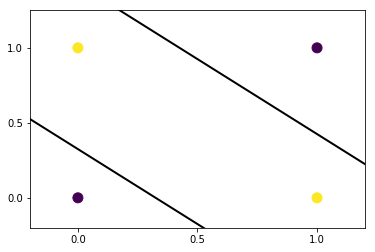

In [10]:
plot_x = np.array([np.min(x[:, 0] - 0.2), np.max(x[:, 1]+0.2)])
plot_y =  -1 / W[1, 0] * (W[0, 0] * plot_x + b[0])
plot_y = np.reshape(plot_y, [2, -1])
plot_y = np.squeeze(plot_y)

plot_y2 = -1 / W[1, 1] * (W[0, 1] * plot_x + b[1])
plot_y2 = np.reshape(plot_y2, [2, -1])
plot_y2 = np.squeeze(plot_y2)

y = np.reshape(y, [4]) 

plt.scatter(x[:, 0], x[:, 1], c=y, s=100, cmap='viridis')
plt.plot(plot_x, plot_y, color='k', linewidth=2)
plt.plot(plot_x, plot_y2, color='k', linewidth=2)
plt.xlim([-0.2, 1.2]); plt.ylim([-0.2, 1.25]);
plt.xticks([0.0, 0.5, 1.0])
plt.yticks([0.0, 0.5, 1.0])
plt.show()